In [1]:
import numpy as np
import seaborn as sns
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
from ndd_utils import calculate_dissim
import pandas as pd

# Comparing Discriminability

We will run the same kernels on the [MAMI dataset](https://www.biorxiv.org/content/10.1101/2022.03.11.483995v1) (unmatched).

## Load Data

In [2]:
from pathlib import Path

graphs = np.zeros((225, 200, 200))
species_list = []

npy_files = Path('../mami_data/conn').glob('*')
for i, file in enumerate(npy_files):
    graphs[i] = np.load(file)
    filestr = str(file).split('/')[-1]
    filestr = filestr.split('.')[0]
    species_list.append(filestr)

print(len(species_list))
    

225


In [3]:
# construct labels based on taxonomy orders
info_df = pd.read_csv('../mami_data/info.csv')
filenames = info_df.pop("Filename").to_list()
orders = info_df.pop("Order").to_list()

order_mapper = {}
for i, filename in enumerate(filenames):
    if orders[i] == 'Artiodactyla':
        orders[i] = 'Cetartiodactyla'
    order_mapper[filename] = orders[i]

labels = list(map(order_mapper.get, species_list))

mapper = {}

for i, label in enumerate(set(labels)):
    mapper[label] = i
y = list(map(mapper.get, labels))

print(len(labels))
print(len(y))

225
225


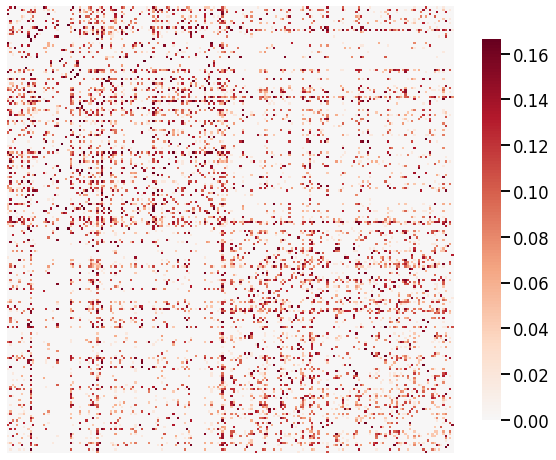

In [18]:
# Visualize one of the graphs
ax = heatmap(graphs[0], context='talk', transform='simple-all')
ax.figure.set_facecolor('w')

## Kernels

The following is a list of kernels that were implemented. We divided them into three major groups based on the metrics used.

- Global: Density, Average Edge Weight, Average of Adjacency Matrix
- Node-wise: Node Degree, Node Strength
- Edge-wise: Edge Weights

## Global Kernels

The following kernels are constructed using characteristics of the entire graph. For each metric, the absolute differences between every pair of graphs were calculated and visualized using a heatmap.

### Density
The density of each graph was calculated by dividing the number of edges by the number of possible nodes.

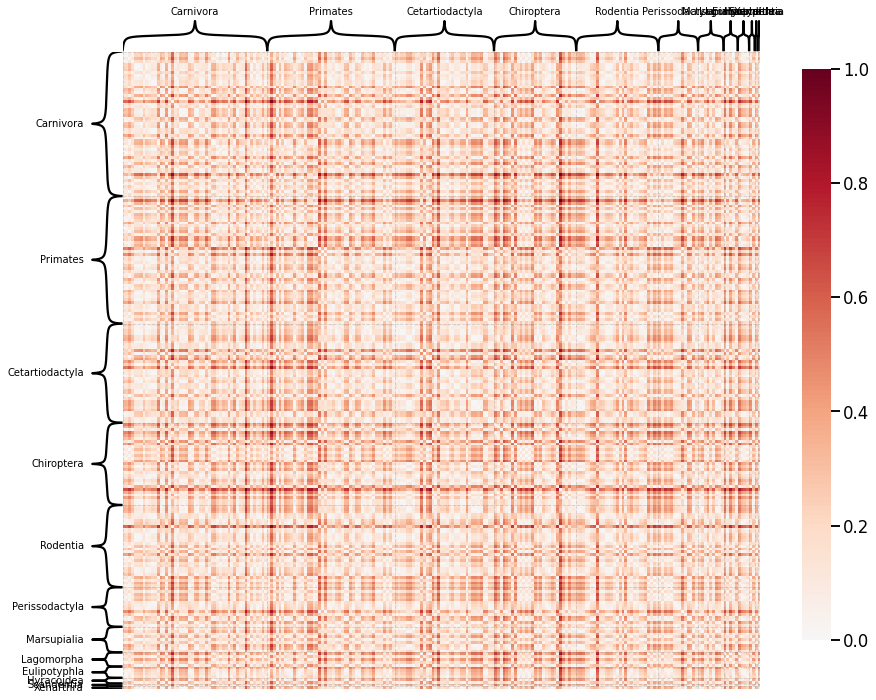

In [20]:
scaled_density_dissim = calculate_dissim(graphs, method="density", norm=None, normalize=True)

ax = heatmap(scaled_density_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=10, figsize=(15,15))
ax.figure.set_facecolor('w')

### Average Edge Weight

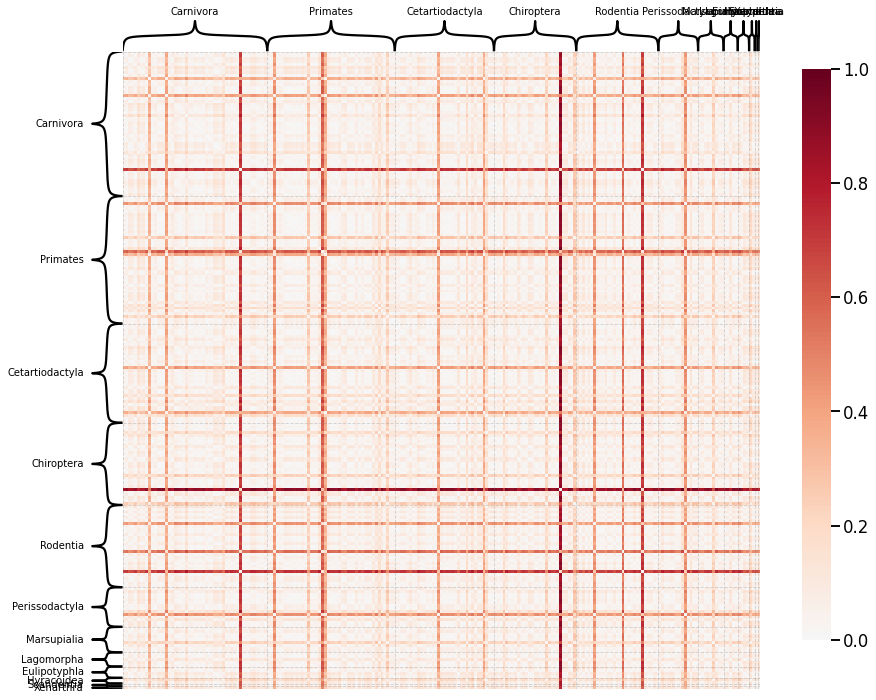

In [21]:
scaled_avgedgeweight_dissim = calculate_dissim(graphs, method="avgedgeweight", norm=None, normalize=True)

ax = heatmap(scaled_avgedgeweight_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=10, figsize=(15,15))
ax.figure.set_facecolor('w')

### Average of the Adjacency Matrix
Note that when we calculate the average of each adjacency matrix, we include edges that do not exist, whereas we only consider those with nonzero values when we calculate the average edge weight of each graph.

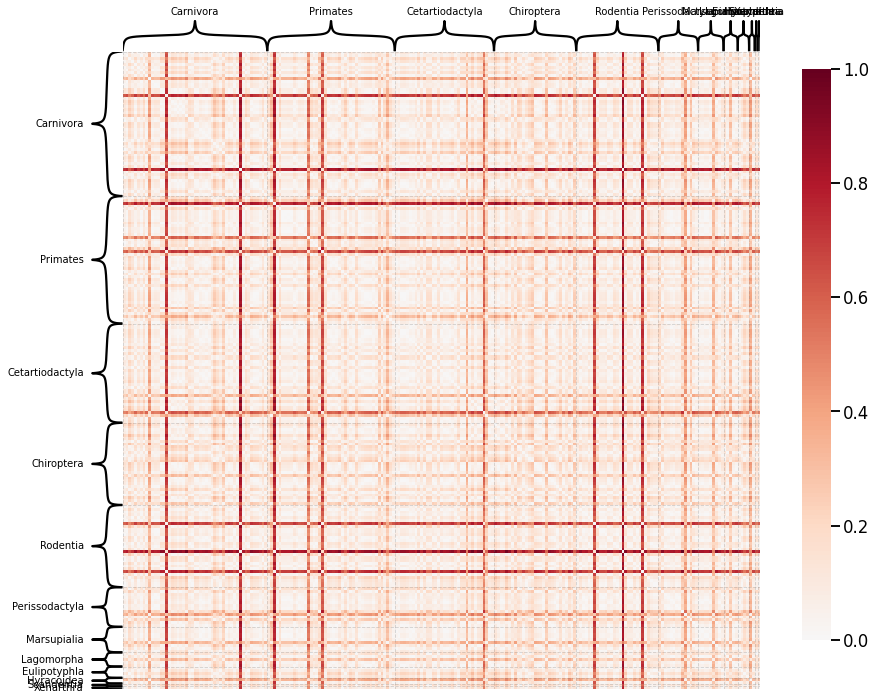

In [31]:
scaled_avgadjmat_dissim = calculate_dissim(graphs, method="avgadjmatrix", norm=None, normalize=True)

ax = heatmap(scaled_avgadjmat_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=10, figsize=(15,15))
ax.figure.set_facecolor('w')

For the kernels that follow, they assume that the nodes are matched. However, we are working with an umatched datset. Thus, we used the following function to calculate discriminability matrices that uses the [two-sample Kolmogorov-Smirnov test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) to compare two distributions. 

In [11]:
from scipy.stats import ks_2samp
from scipy.special import kl_div
from hyppo.independence import Dcorr
from scipy.spatial import distance
from graspologic.utils import pass_to_ranks

def calculate_dissim_unmatched(graphs, method="density", normalize=True):
    """ Calculate the dissimilarity matrix using the input kernel. """
    if method == "degree":
        metric = np.zeros((graphs.shape[0], graphs.shape[1]))
        for i, graph in enumerate(graphs):
            for j, node in enumerate(graph):
                metric[i, j] = np.count_nonzero(node)
    
    elif method == "strength":
        metric = np.zeros((graphs.shape[0], graphs.shape[1]))
        for i, graph in enumerate(graphs):
            #graph = pass_to_ranks(graph)
            for j, node in enumerate(graph):
                metric[i, j] = np.sum(node)

    elif method == "edgeweight":
        metric = graphs
    
    else:
        print("Not a valid kernel name.")
    
    dissim_matrix = np.zeros((len(graphs), len(graphs)))
    for i, metric1 in enumerate(metric):
        for j, metric2 in enumerate(metric):
            diff, _ = ks_2samp(metric1, metric2, mode='asymp')
            #diff = kl_div(metric1, metric2)
            #diff = hellinger1(metric1, metric2)
            #diff = Dcorr().statistic(metric1.reshape(1,-1), metric2.reshape(1,-1))
            #diff = distance.correlation(metric1, metric2)
            dissim_matrix[i, j] = diff
            
    if normalize:
        dissim_matrix = dissim_matrix / np.max(dissim_matrix)
    
    return dissim_matrix

## Node-wise Kernels
The following kernels use characteristics related to the nodes of each graph. For each metric, we calculate the two-sample Kolmogorov-Smirnov statistic between each graph.

### Node Degrees
The degree of a node in a graph is the number of nodes each node is adjacent to, aka the number of edges each node has.

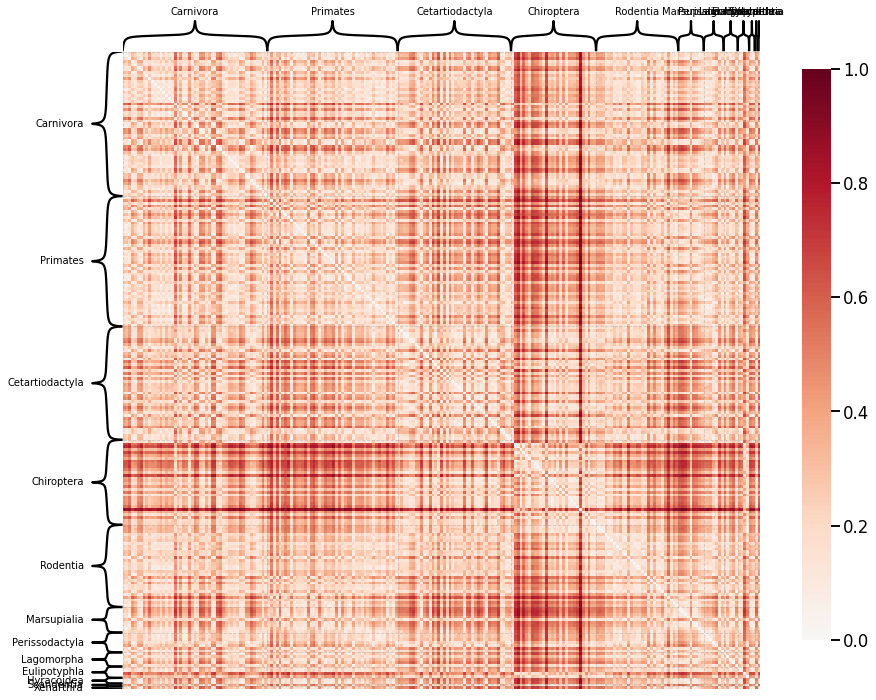

In [8]:
scaled_nodedeg_dissim_l1 = calculate_dissim_unmatched(graphs, method="degree", normalize=True)

ax = heatmap(scaled_nodedeg_dissim_l1, context="talk", inner_hier_labels=labels, hier_label_fontsize=10, figsize=(15,15))
ax.figure.set_facecolor('w')

### Node Strength
Node strength, unlike node degree, takes into account the weight of the edges each node has. We calculate node strength by finding the sum of the edge weights for each node.

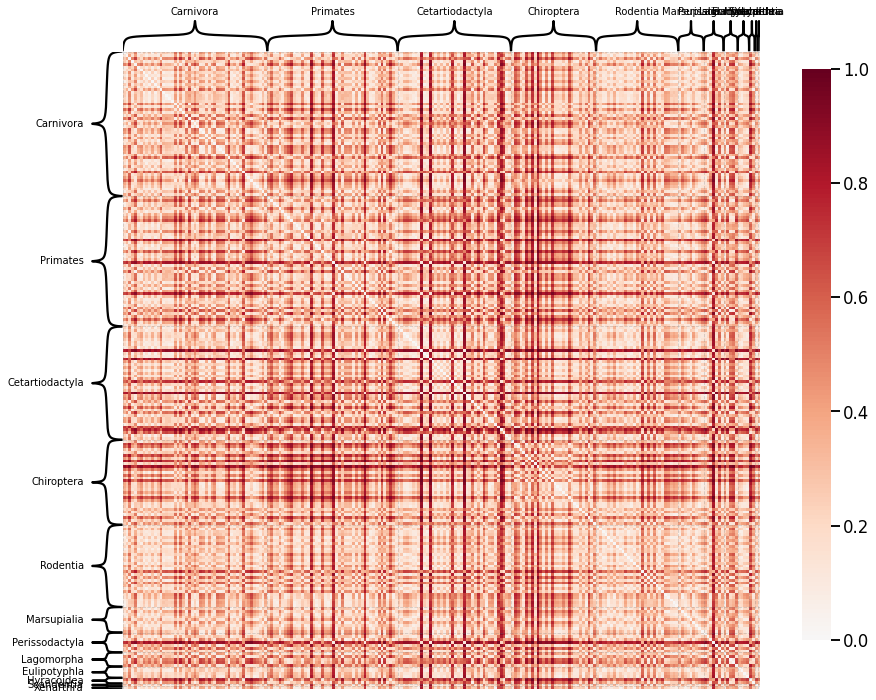

In [9]:
scaled_nodestr_dissim_l1 = calculate_dissim_unmatched(graphs, method="strength", normalize=True)

ax = heatmap(scaled_nodestr_dissim_l1, context="talk", inner_hier_labels=labels, hier_label_fontsize=10, figsize=(15,15))
ax.figure.set_facecolor('w')

## Edge-wise Kernels
The following kernels use characteristics related to the edges of each graph. For each metric, we calculated the two-sample Kolmogrov-Smirnov statistic between each graph.

### Edge weights
Here we compare the weights of each edge between graphs by simply subtracting one adjacency matrix from another.

In [12]:
scaled_edgeweight_dissim_l1 = calculate_dissim_unmatched(graphs, method="edgeweight", normalize=True)

ax = heatmap(scaled_edgeweight_dissim_l1, context="talk", inner_hier_labels=labels, hier_label_fontsize=10, figsize=(15,15))
ax.figure.set_facecolor('w')

ValueError: object too deep for desired array

### Latent Distribution Test

Instead of using Omnibus Embedding, we will use the [latent distribution test](https://microsoft.github.io/graspologic/latest/reference/reference/inference.html#graspologic.inference.latent_distribution_test) from Graspologic that determines whether two random dot product graphs with no known matching between the vertices have the same distributions of latent positions.

In [3]:
from graspologic.inference import latent_distribution_test

# create dissimilarity matrix
latent_dissim = np.zeros((len(graphs), len(graphs)))
for i, graph1 in enumerate(graphs):
    for j, graph2 in enumerate(graphs):
        statistic, _, _ = latent_distribution_test(graph1, graph2, test='dcorr', metric='euclidean', \
            n_components=None, n_bootstraps=0, align_type='seedless_procrustes')
        latent_dissim[i, j] = statistic

# plot heatmap
scaled_latent_dissim = latent_dissim / np.max(latent_dissim)

ax = heatmap(scaled_latent_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=10, figsize=(15,15))
ax.figure.set_facecolor('w')

NameError: name 'graphs' is not defined

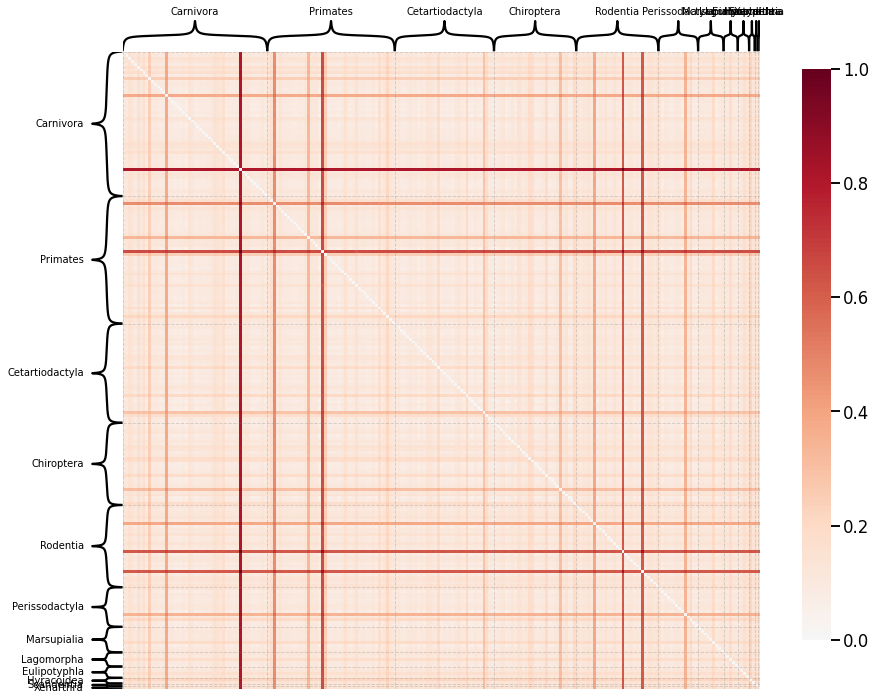

In [30]:
# create dissimilarity matrix
omni_matrix = np.zeros((len(graphs), len(graphs)))
for i, embedding1 in enumerate(omni_embedding):
    for j, embedding2 in enumerate(omni_embedding):
        dist = np.linalg.norm(embedding1 - embedding2, ord="fro")
        omni_matrix[i, j] = dist

# plot heatmap
scaled_omni_dissim = omni_matrix / np.max(omni_matrix)

ax = heatmap(scaled_omni_dissim, context="talk", inner_hier_labels=labels, hier_label_fontsize=10, figsize=(15,15))
ax.figure.set_facecolor('w')

## Discriminability Plot

We will use the [One Sample Discriminability](https://mgc.neurodata.io/api/generated/hyppo.discrim.discrimonesample) test from [hyppo](https://mgc.neurodata.io/index.html) to compare the performance of each kernel. The distance matrix of the embeddings ater using Omnibus is included as a point of comparison.

Text(0, 0.5, 'Discriminability')

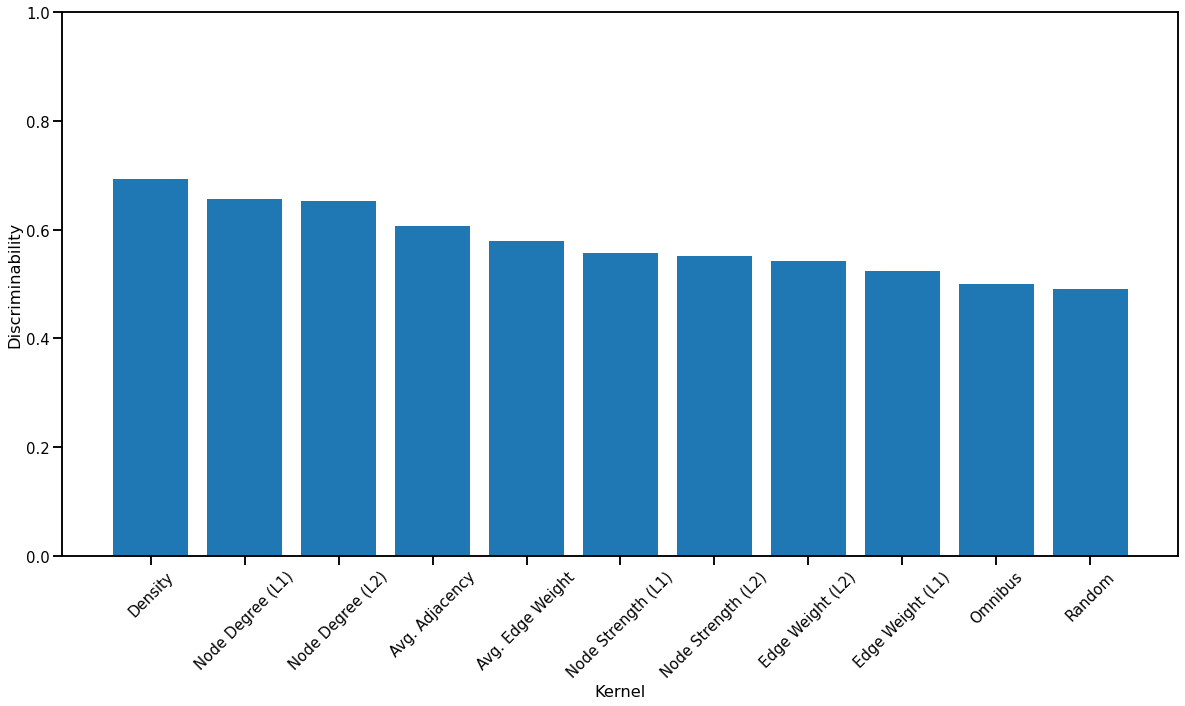

In [90]:
from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample()

# construct integer labels
mapper = {}
unique_labels = np.unique(np.array(labels))
for i, label in enumerate(unique_labels):
    mapper[label] = i

#mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in labels])

# construct random matrix with zero diagonal
np.random.seed(42)
scaled_random = np.random.rand(len(graphs), len(graphs))
np.fill_diagonal(scaled_random, 0)

# calculate discriminability for each kernel matrix
discrim_omni = discrim.statistic(scaled_omni_dissim, y)
discrim_density = discrim.statistic(scaled_density_dissim, y)
discrim_avgedgeweight = discrim.statistic(scaled_avgedgeweight_dissim, y)
discrim_avgadjmat = discrim.statistic(scaled_avgadjmat_dissim, y)
discrim_nodedeg_l1 = discrim.statistic(scaled_nodedeg_dissim_l1, y)
discrim_nodedeg_l2 = discrim.statistic(scaled_nodedeg_dissim_l2, y)
discrim_nodestr_l1 = discrim.statistic(scaled_nodestr_dissim_l1, y)
discrim_nodestr_l2 = discrim.statistic(scaled_nodestr_dissim_l2, y)
discrim_edgeweight_l1 = discrim.statistic(scaled_edgeweight_dissim_l1, y)
discrim_edgeweight_l2 = discrim.statistic(scaled_edgeweight_dissim_l2, y)
discrim_random = discrim.statistic(scaled_random, y)

# plot bar graph in descending order
kernels = ['Omnibus', 'Density', 'Avg. Edge Weight', 'Avg. Adjacency', 'Node Degree (L1)', 'Node Degree (L2)', 'Node Strength (L1)', \
    'Node Strength (L2)', 'Edge Weight (L1)', 'Edge Weight (L2)', 'Random']
stats = [discrim_omni, discrim_density, discrim_avgedgeweight, discrim_avgadjmat, discrim_nodedeg_l1, discrim_nodedeg_l2, \
    discrim_nodestr_l1, discrim_nodestr_l2, discrim_edgeweight_l1, discrim_edgeweight_l2, discrim_random]

discrim_dict = {}
for i, kernel in enumerate(kernels):
    discrim_dict[kernel] = stats[i]

sorted_discrim_dict = dict(sorted(discrim_dict.items(), key=lambda x:x[1], reverse=True))

sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(20,10), facecolor='w')
plt.bar(list(sorted_discrim_dict.keys()), list(sorted_discrim_dict.values()))
plt.xticks(rotation=45)
plt.ylim([0, 1.0])
plt.xlabel('Kernel')
plt.ylabel('Discriminability')
